<a href="https://colab.research.google.com/github/azzindani/04_Bio_Medical/blob/main/DCM_BP_Brain_MRI_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 00 Huggingface Set Up

In [1]:
from huggingface_hub import login
from huggingface_hub import hf_hub_download

### 00.01 Log In to Huggingface

In [2]:
hf_token = ''

login(token = hf_token)
print("Logged in to Hugging Face successfully!")

Logged in to Hugging Face successfully!


### 00.02 Download BiomedParse Model

In [3]:
model_file = hf_hub_download(repo_id = 'microsoft/BiomedParse', filename = 'biomedparse_v1.pt', local_dir = 'pretrained')

print(f"Downloaded model file to: {model_file}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


biomedparse_v1.pt:   0%|          | 0.00/1.80G [00:00<?, ?B/s]

Downloaded model file to: pretrained/biomedparse_v1.pt


## 01 BiomedParse Set Up

In [4]:
!git clone https://github.com/microsoft/BiomedParse

Cloning into 'BiomedParse'...
remote: Enumerating objects: 1593, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 1593 (delta 78), reused 80 (delta 57), pack-reused 1467 (from 2)
Receiving objects: 100% (1593/1593), 652.52 MiB | 26.35 MiB/s, done.
Resolving deltas: 100% (466/466), done.
Updating files: 100% (583/583), done.
Filtering content: 100% (45/45), 69.68 MiB | 31.91 MiB/s, done.


In [5]:
!pip install -q -r BiomedParse/assets/requirements/requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 57.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.3/867.3 kB 50.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/5

## RESTART RUNTIME AND RECONNECT AGAIN

In [1]:
import os
os.chdir('/content/BiomedParse')
print(os.getcwd())

/content/BiomedParse


## 02 Model Set Up

### 02.01 Import Modules

In [2]:
!pip install -q pydicom nibabel SimpleITK

In [3]:
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pydicom
import imageio

from PIL import Image
from zipfile import ZipFile
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES
from inference_utils.inference import interactive_infer_image
from inference_utils.output_processing import check_mask_stats
from inference_utils.processing_utils import read_dicom, read_rgb
from inference_utils.inference import interactive_infer_image_all
from detectron2.data.datasets.builtin_meta import COCO_CATEGORIES

Deformable Transformer Encoder is not available.


/usr/local/lib/python3.11/dist-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


### 02.02 Load Model

In [4]:
conf_files = 'configs/biomedparse_inference.yaml'
opt = load_opt_from_config_files([conf_files])
opt = init_distributed(opt)

model_file = '../pretrained/biomedparse_v1.pt'

model = BaseModel(opt, build_model(opt)).from_pretrained(model_file).eval().cuda()
with torch.no_grad():
  model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ['background'], is_eval = True)

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map

### 02.03 Define Inference Function

In [5]:
colors_list = [(np.array(color['color'])).tolist() for color in COCO_CATEGORIES]
color_codes = [f'#{color[0]:02x}{color[1]:02x}{color[2]:02x}' for color in colors_list]


def plot_segmentation_dicom(original_image, segmentation_masks, texts):
  original_image = original_image[:, :, :3]
  fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize = (10, 5))
  ax[0].imshow(original_image, cmap = 'gray')
  ax[0].set_title('Original Image')

  for a in ax:
    a.axis('off')

  for i, mask in enumerate(segmentation_masks):
    ax[i+1].set_title(texts[i])
    mask_temp = original_image.copy()
    mask_temp[mask > 0.5] = [255, 0, 0]
    mask_temp[mask <= 0.5] = [0, 0, 0, ]
    ax[i+1].imshow(mask_temp, alpha = 0.9)
    ax[i+1].imshow(original_image, cmap = 'gray', alpha = 0.5)

  plt.show()


def inference_dicom(file_path, text_prompts, is_CT, site = None):
  image = read_dicom(file_path, is_CT, site = site)
  pred_mask = interactive_infer_image(model, Image.fromarray(image), text_prompts)
  plot_segmentation_dicom(image, pred_mask, text_prompts)

  return image, pred_mask


def plot_segmentation_rgb(original_image, segmentation_masks, texts):
  original_image = original_image[:, :, :3]
  fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize = (10, 5))
  ax[0].imshow(original_image, cmap = 'gray')
  ax[0].set_title('Original Image')

  for a in ax:
    a.axis('off')

  for i, mask in enumerate(segmentation_masks):
    ax[i+1].set_title(texts[i])
    mask_temp = original_image.copy()
    mask_temp[mask > 0.5] = [255, 0, 0]
    mask_temp[mask <= 0.5] = [0, 0, 0, ]
    ax[i+1].imshow(mask_temp, alpha = 0.9)
    ax[i+1].imshow(original_image, cmap = 'gray', alpha = 0.5)

  plt.show()


def inference_rgb(file_path, text_prompts):
  image = read_rgb(file_path)
  pred_mask = interactive_infer_image(model, Image.fromarray(image), text_prompts)
  plot_segmentation_rgb(image, pred_mask, text_prompts)

  return image, pred_mask


def plot_segmentation_recognition(original_image, segmentation_masks, texts):
  original_image = original_image[:, :, :3]
  mask_temp = original_image.copy()
  for i, mask in enumerate(segmentation_masks):
    mask_temp[mask > 0.5] = colors_list[i]

  image_to_show = (original_image * 0.5 + mask_temp * 0.5) / 255.0
  plt.imshow(image_to_show)
  plt.axis('off')

  for i, text in enumerate(texts):
    plt.plot([], [], '.', color=color_codes[i], markersize = 20, label = text)

  plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
  plt.show()


def inference_recognition(file_path, image_type, p_value_threshold = None):
  image = read_rgb(file_path)

  predictions = interactive_infer_image_all(model, Image.fromarray(image), image_type, p_value_threshold)
  targets = list(predictions.keys())
  pred_mask = [predictions[t] for t in targets]
  plot_segmentation_recognition(image, pred_mask, targets)

  return image, pred_mask

## 03 Import Datasets

### 03.01 Download Datasets

In [6]:
url = 'https://www.kaggle.com/datasets/shlezinger/brain-mri-data'

url_path = url.split('datasets/')[1]
url_path

'shlezinger/brain-mri-data'

In [7]:
!kaggle datasets download -d {url_path}

Dataset URL: https://www.kaggle.com/datasets/shlezinger/brain-mri-data
License(s): unknown
 97% 432M/445M [00:03<00:00, 81.9MB/s]
100% 445M/445M [00:04<00:00, 116MB/s] 


### 03.02 Extract Dataset

In [8]:
os.listdir()

['.git',
 '.gitignore',
 'modeling',
 'pipeline',
 'datasets',
 'CT-Abdomen_rotate.gif',
 'utilities',
 'biomedparse_working.txt',
 'docker',
 'inference_examples_NIFTI.ipynb',
 'environment.yml',
 '.gitattributes',
 'inference_examples_RGB.ipynb',
 'assets',
 'figures',
 '__init__.py',
 'SECURITY.md',
 'inference_examples_recognition.ipynb',
 'examples',
 'LICENSE',
 'entry.py',
 'README.md',
 'trainer',
 'configs',
 'inference_utils',
 'biomedparse_datasets',
 'inference_examples_DICOM.ipynb',
 'example_prediction.py',
 'inference_colab_demo.ipynb',
 'brain-mri-data.zip']

In [9]:
zipfile = ZipFile('brain-mri-data.zip')
zipfile.extractall() #'''

### 03.03 Get File List

In [10]:
root_dir = './'

file_format = '.dcm'
n = 6
file_paths = []

for root, dirs, files in os.walk(root_dir):
  for file in files:
    if file.endswith(file_format):
      file_paths.append(os.path.join(root, file))

    if len(file_paths) >= n:
      break
  if len(file_paths) >= n:
    break

#file_paths

## 04 Dicom Preview

### **Common DICOM Modalities and Their Meanings**
| **Modality Code** | **Description** |
|-------------------|----------------|
| **CR**  | Computed Radiography (Digital X-ray) |
| **CT**  | Computed Tomography (CT Scan) |
| **MR**  | Magnetic Resonance Imaging (MRI) |
| **US**  | Ultrasound |
| **XA**  | X-Ray Angiography |
| **MG**  | Mammography |
| **DX**  | Digital Radiography |
| **NM**  | Nuclear Medicine |
| **PT**  | Positron Emission Tomography (PET) |
| **RF**  | Radio Fluoroscopy |
| **DXA** | Bone Densitometry (Dual-Energy X-ray Absorptiometry) |
| **OPT** | Ophthalmic Tomography |
| **OCT** | Optical Coherence Tomography |
| **ES**  | Endoscopy |
| **ECG** | Electrocardiography |
| **EEG** | Electroencephalography |
| **XC**  | External Camera Photography |

In [11]:
file_path = file_paths[1]
file_path

'./dicom-flair/dicom-flair/59/1-01.dcm'

In [12]:
dicom_data = pydicom.dcmread(file_path)
image_data = dicom_data.pixel_array

image_data = ((image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data)) * 255).astype(np.uint8)

png_path = 'output_dcm.png'
imageio.imwrite(png_path, image_data)

In [13]:
print("DICOM Properties: \n", 100 * '=')
#for elem in dicom_data:
#  print(f"{elem.tag} {elem.name}: {elem.value}")

print(' ', 100 * '=', "\nAdditional DICOM Properties:\n", 100 * '=')
print(f"Patient's Name: {dicom_data.PatientName}\n", 100 * '=')
print(f"Patient ID: {dicom_data.PatientID}\n", 100 * '=')
print(f"Patient Birth Date: {dicom_data.PatientBirthDate}\n", 100 * '=')
print(f"Patient Sex: {dicom_data.PatientSex}\n", 100 * '=')
print(f"Study Date: {dicom_data.StudyDate}\n", 100 * '=')
#print(f"Study Description: {dicom_data.StudyDescription}\n", 100 * '=')
#print(f"Series Description: {dicom_data.SeriesDescription}\n", 100 * '=')
print(f"Modality: {dicom_data.Modality}\n", 100 * '=')
print(f"Rows: {dicom_data.Rows}, Columns: {dicom_data.Columns}\n", 100 * '=')
print(f"Pixel Spacing: {dicom_data.PixelSpacing}\n", 100 * '=')
#print(f"Manufacturer: {dicom_data.Manufacturer}\n", 100 * '=')
#print(f"Body Part Examined: {dicom_data.BodyPartExamined}\n", 100 * '=')
print(f"SOP Instance UID: {dicom_data.SOPInstanceUID}\n", 100 * '=')

DICOM Properties: 
Additional DICOM Properties:
Patient's Name: C3L-00349
Patient ID: C3L-00349
Patient Birth Date: 
Patient Sex: F
Study Date: 20000105
Modality: MR
Rows: 512, Columns: 512
Pixel Spacing: [0.4688, 0.4688]
SOP Instance UID: 1.3.6.1.4.1.14519.5.2.1.2857.3707.123793376592661930741163260380


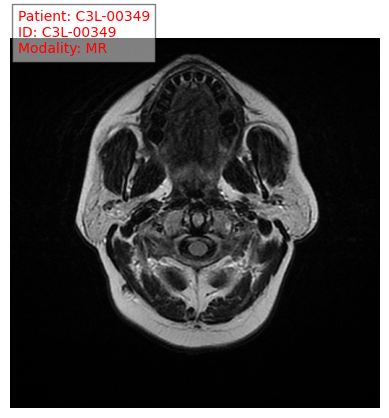

In [14]:
plt.imshow(image_data, cmap = 'gray')

text = f"Patient: {dicom_data.PatientName}\nID: {dicom_data.PatientID}\nModality: {dicom_data.Modality}"
plt.text(10, 20, text, fontsize = 10, color = 'red', bbox = dict(facecolor = 'white', alpha = 0.5))
plt.axis('off')
plt.show()

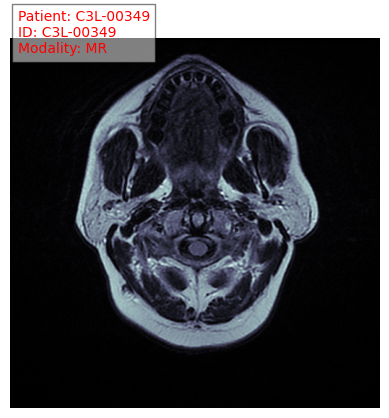

In [15]:
plt.imshow(image_data, cmap = 'bone')

text = f"Patient: {dicom_data.PatientName}\nID: {dicom_data.PatientID}\nModality: {dicom_data.Modality}"
plt.text(10, 20, text, fontsize = 10, color = 'red', bbox = dict(facecolor = 'white', alpha = 0.5))
plt.axis('off')
plt.show()

## 05 Run Inference & Result Preview

### 05.01 Inference Dicom

In [23]:
text_prompt = ['edema', 'tumor core', 'whole tumor']

#image, pred_mask = inference_dicom(file_paths[1], text_prompt, is_CT = False, site = 'MRI-FLAIR-Brain')

In [24]:
#for file_path in file_paths[1:]:
#  image, pred_mask = inference_dicom(file_path, text_prompt, is_CT = False, site = 'MRI-FLAIR-Brain')

### 05.02 Inference RGB

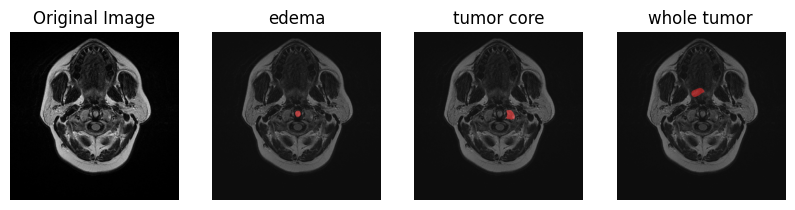

edema P-value: 0.003686424585029237
tumor core P-value: 0.0037719871447491667


In [17]:
text_prompt = ['edema', 'tumor core', 'whole tumor']
modality = 'MRI-FLAIR-Brain'

dicom_data = pydicom.dcmread(file_paths[1])
image_data = dicom_data.pixel_array

image_data = ((image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data)) * 255).astype(np.uint8)

png_path = 'output_dcm.png'
imageio.imwrite(png_path, image_data)

image, pred_mask = inference_rgb(png_path, text_prompt)

for i in range(len(pred_mask) - 1):
  adj_pvalue = check_mask_stats(image, pred_mask[i] * 255, modality, text_prompt[i])
  print(f'{text_prompt[i]} P-value: {adj_pvalue}')

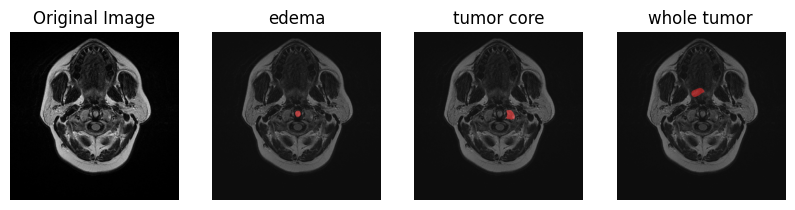

edema P-value: 0.003686424585029237
tumor core P-value: 0.0037719871447491667


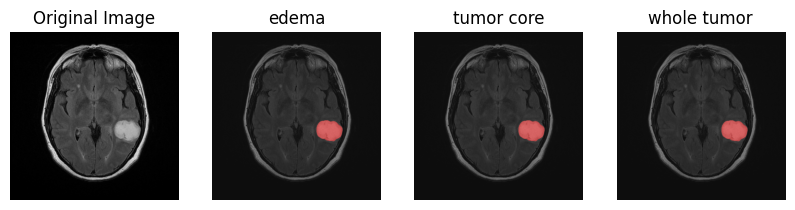

edema P-value: 0.11992160985302029
tumor core P-value: 0.09598037130890913


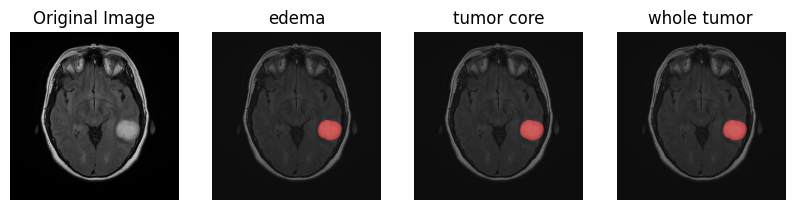

edema P-value: 0.05935081617692317
tumor core P-value: 0.04246804002795127


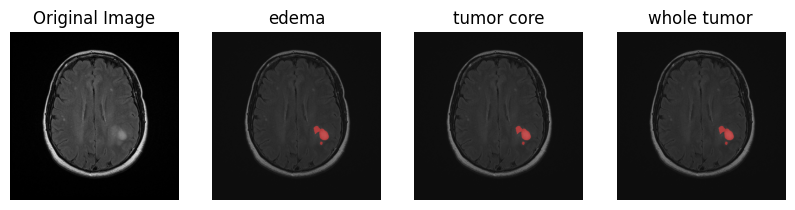

edema P-value: 0.024061470150857054
tumor core P-value: 0.006470058729839182


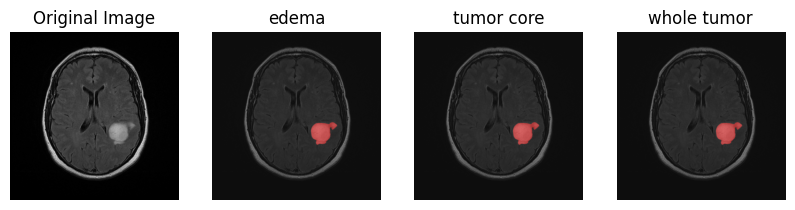

edema P-value: 0.05790125206541291
tumor core P-value: 0.04141205855234448


In [18]:
for file_path in file_paths[1:]:
  dicom_data = pydicom.dcmread(file_path)
  image_data = dicom_data.pixel_array

  image_data = ((image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data)) * 255).astype(np.uint8)

  png_path = 'output_dcm.png'
  imageio.imwrite(png_path, image_data)

  image, pred_mask = inference_rgb(png_path, text_prompt)
  for i in range(len(pred_mask) - 1):
    adj_pvalue = check_mask_stats(image, pred_mask[i] * 255, modality, text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### 05.03 Inference Recognition

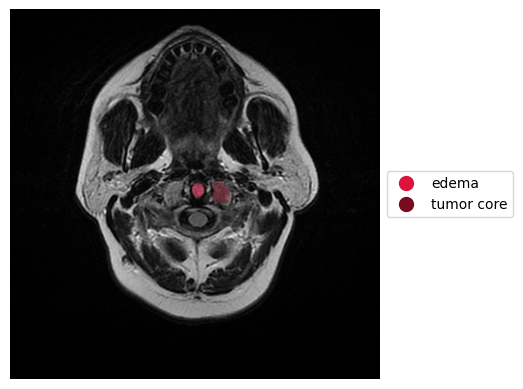

In [19]:
modality = 'MRI-FLAIR-Brain'

dicom_data = pydicom.dcmread(file_paths[1])
image_data = dicom_data.pixel_array

image_data = ((image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data)) * 255).astype(np.uint8)

png_path = 'output_dcm.png'
imageio.imwrite(png_path, image_data)

image, pred_mask = inference_recognition(png_path, modality)

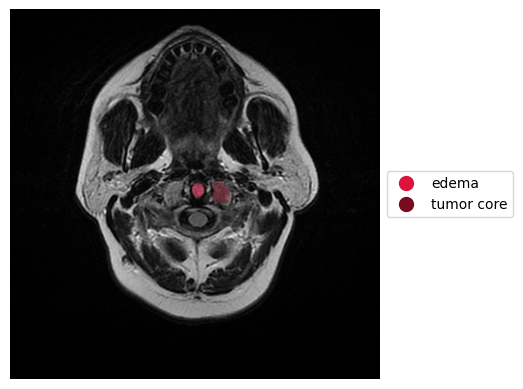

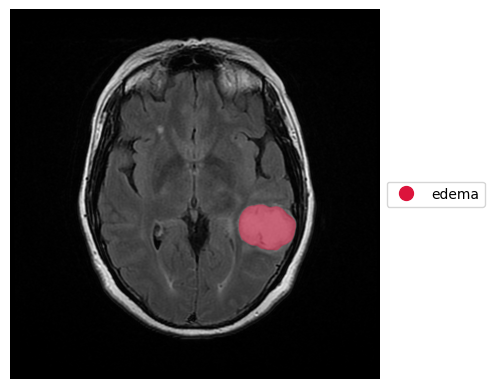

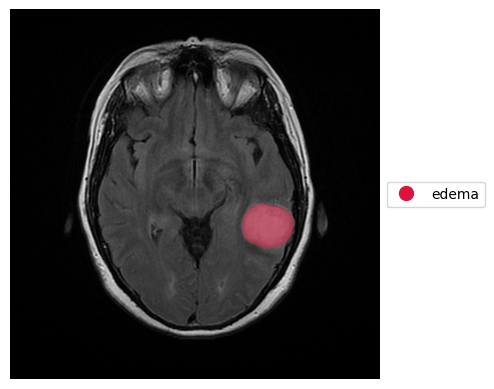

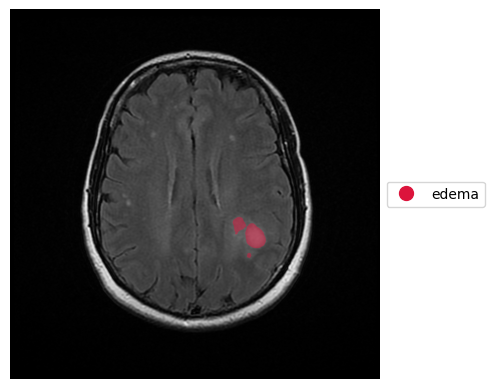

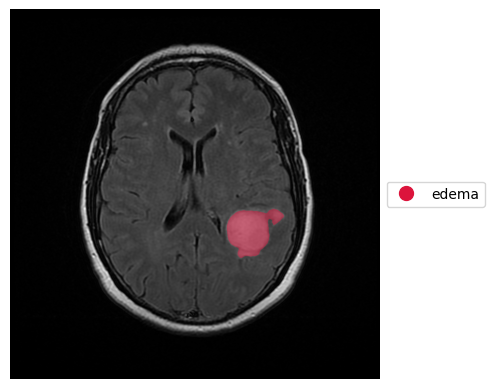

In [20]:
for file_path in file_paths[1:]:
  dicom_data = pydicom.dcmread(file_path)
  image_data = dicom_data.pixel_array

  image_data = ((image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data)) * 255).astype(np.uint8)

  png_path = 'output_dcm.png'
  imageio.imwrite(png_path, image_data)

  image, pred_mask = inference_recognition(png_path, modality)